In [53]:
import os
import mne
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mne_connectivity import spectral_connectivity_epochs, seed_target_indices

from shared.helper_functions import save_figure, select_folder, select_or_create_folder
from settings_general import low_qual_chans, freq_bands_eeg, subject_id_batch_cage_dict

In [2]:
sns.set_theme()

In [3]:
palette = {'DRD2-WT': '#427C99', 'DRD2-KO': '#AF5541'}
palette_gr = {'DRD2-WT':'#6A8D73', 'DRD2-KO':'#984447'}

In [4]:
boris_folder = select_folder("Select the folder that holds the BORIS behaviour tracking files")

2024-05-08 09:21:31.026 python[12364:491877] +[CATransaction synchronize] called within transaction


In [5]:
boris_folder

'/Users/olledejong/Documents/MSc_Biology/ResearchProject2/rp2_data/social_interaction/input/behavioural_data'

In [7]:
def merge_event_rows(beh_data):
    merged_df = pd.concat([
        beh_data.iloc[::2].reset_index(drop=True),  # only keep each start row
        beh_data.iloc[::2].reset_index(drop=True)['Image index'].rename('Frame start'),  # interaction start frame
        beh_data.iloc[1::2].reset_index(drop=True)['Image index'].rename('Frame stop'),  # interaction stop frame
        beh_data.iloc[1::2].reset_index(drop=True)['Time'] - beh_data.iloc[::2]['Time'].reset_index(drop=True),
        # duration
    ], axis=1)
    # rename the last column as it represents the duration of the interaction
    merged_df = merged_df.set_axis([*merged_df.columns[:-1], 'Interaction duration'], axis=1)
    # drop the columns we don't need
    cols_to_drop = [
        'Image index', 'Time', 'Observation type', 'Source', 'Time offset (s)', 'Subject', 'Comment', 'Image file path',
        'Description', 'Behavioral category', 'Behavior type'
    ]
    return merged_df.drop(columns=cols_to_drop)

In [30]:
beh_df = pd.DataFrame()

for file in os.listdir(boris_folder):
    if not file.endswith('.xlsx'):
        continue
    beh_data = pd.read_excel(os.path.join(boris_folder, file))
    batch_cage = file.split('.')[0]
    subject_id = [key for key, value in subject_id_batch_cage_dict.items() if value == batch_cage][0]

    for event_type in beh_data['Behavior'].unique():
        beh_dat_event = beh_data[beh_data['Behavior'] == event_type]
        starts = beh_dat_event[beh_dat_event['Behavior type'] == 'START']
        stops = beh_dat_event[beh_dat_event['Behavior type'] == 'STOP']

        if len(stops) < len(starts):
            print(f'({batch_cage}, {subject_id}) Number of STOPs is smaller than number of STARTs for {event_type}')
            if beh_dat_event.iloc[-1]['Behavior type'] == 'START':
                print('Removing last row because it is of type START')
                beh_dat_event = beh_dat_event.drop(beh_dat_event.index[-1])
            else:
                print(f'Number of STOPs is smaller than number of STARTs, but this is not caused by a START at '
                      f'the last row of the dataframe. Skipping..')
                continue
        if len(starts) < len(stops):
            print(f'({batch_cage}, {subject_id}) Number of STARTs is smaller than number of STOPs for {event_type}')
            if beh_dat_event.iloc[0]['Behavior type'] == 'STOP':
                print('Removing first row because it is of type STOP')
                beh_dat_event = beh_dat_event.drop(beh_dat_event.index[0])
            else:
                print(f'Number of STARTs is smaller than number of STOPs, but this is not caused by a STOP at '
                      f'the first row of the dataframe. Skipping..')
                continue

        beh_dat_event = merge_event_rows(beh_dat_event)
        # merge the start and stop rows and calculate some stuff (interaction duration etc)
        beh_dat_event.insert(1, 'subject_id', subject_id)
        beh_df = pd.concat([beh_df, beh_dat_event], axis=0)

(batch2_cage3, 79604) Number of STOPs is smaller than number of STARTs for sniff
Removing last row because it is of type START
(batch2_cage2, 79592) Number of STARTs is smaller than number of STOPs for sniff
Removing first row because it is of type STOP
(batch1_cage1, 78211) Number of STARTs is smaller than number of STOPs for sniff
Removing first row because it is of type STOP
(batch2_cage4, 79602) Number of STOPs is smaller than number of STARTs for follow
Removing last row because it is of type START
(batch5b_cage1, 81217) Number of STARTs is smaller than number of STOPs for sniff
Removing first row because it is of type STOP
(batch3_cage3, 80108) Number of STARTs is smaller than number of STOPs for sniff
Removing first row because it is of type STOP


In [31]:
beh_df

,Observation id,subject_id,Observation date,Observation duration,Media duration (s),FPS,Behavior,Media file name,Frame start,Frame stop,Interaction duration
0,B5C4 redo,81193,2024-02-16 12:23:23.147,274.502,1629.924,30.0,sniff,C:/Users/rebek/Downloads/drd2_batch5_social-in...,39276,39288,0.400
1,B5C4 redo,81193,2024-02-16 12:23:23.147,274.502,1629.924,30.0,sniff,C:/Users/rebek/Downloads/drd2_batch5_social-in...,39802,39823,0.701
2,B5C4 redo,81193,2024-02-16 12:23:23.147,274.502,1629.924,30.0,sniff,C:/Users/rebek/Downloads/drd2_batch5_social-in...,39990,39996,0.199
3,B5C4 redo,81193,2024-02-16 12:23:23.147,274.502,1629.924,30.0,sniff,C:/Users/rebek/Downloads/drd2_batch5_social-in...,40587,40596,0.300
4,B5C4 redo,81193,2024-02-16 12:23:23.147,274.502,1629.924,30.0,sniff,C:/Users/rebek/Downloads/drd2_batch5_social-in...,41150,41157,0.234
...,...,...,...,...,...,...,...,...,...,...,...
11,B1C3,78227,2024-02-15 13:41:11.468,284.706,1607.620,30.0,follow,D:/BORIS videos/B1C3.mp4,43053,43073,0.667
12,B1C3,78227,2024-02-15 13:41:11.468,284.706,1607.620,30.0,follow,D:/BORIS videos/B1C3.mp4,43078,43093,0.500
13,B1C3,78227,2024-02-15 13:41:11.468,284.706,1607.620,30.0,follow,D:/BORIS videos/B1C3.mp4,43110,43117,0.233
14,B1C3,78227,2024-02-15 13:41:11.468,284.706,1607.620,30.0,follow,D:/BORIS videos/B1C3.mp4,43190,43243,1.767


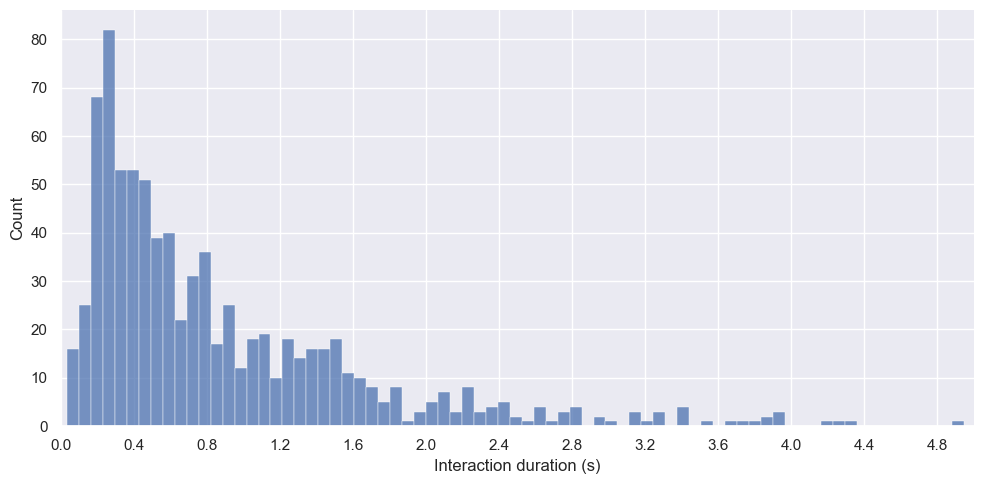

In [57]:
sns.displot(beh_df['Interaction duration'], bins=200, aspect=2)
plt.xlabel('Interaction duration (s)')
plt.xticks(np.arange(0, 5, 0.4))
plt.xlim(0, 5)
plt.show()